- KEYWORDS: numpy.linalg.solve


## Linear regression



In linear regression, we seek to find models in the form $y = a_{0} f_{0}(x) + a_{1} f_{1}(x) + ... + a_{n} f_{n}(x) + \epsilon$, where $a_{i}$ are coefficients to be determined, and &epsilon; are the residual errors. We call this linear regression because the model is linear in the unknown coefficients $a_{i}$. The functions can be any function of $x$. In the function `numpy.polyfit` these functions are polynomials in $x$.

If we are given some data as pairs of (x, y), we can construct a set of equations of the form:

$[f_{0}(x_{i}), f_{1}(x_{i}), ..., f_{n}(x_{i})]\cdot[a_{0}, a_{1}, ...,  a_{n}]^T = y_{i}$

There will be one of these equations for every data point, so we end up with a matrix equation that looks like:

$\mathbf{X} \mathbf{a} = \mathbf{y}$

There are *usually* more data points than in the vector of $\mathbf{a}$, so the shapes of these arrays are not suitable to solve directly. You can of course set up an objective function and use `scipy.optimize.minimize`, but there is a better approach.

To be a little more specific, suppose we have $m$ pairs of $(x, y)$ data points, and we want to fit a model containing $n$ parameters. Then, the dimensions of the $\mathbf{X}$ will be $(m, n)$, the dimensions of $\mathbf{a}$ will be $(n, 1)$, and the dimensions of $\mathbf{y}$ will be $(m, 1)$.  We have more equations than unknowns here, and we cannot use `numpy.linalg.solve` because \mathbf{X} is not square. Note that if it was square, we would be doing the kind of interpolation we described in the last lecture.

We can modify the equation though if we *left multiply* each side of the equation by $\mathbf{X}^T$.

$\mathbf{X}^T \mathbf{X} \mathbf{a} = \mathbf{X}^T \mathbf{y}$

The array $\mathbf{X}^T \mathbf{X}$ now has the shape $(n, m) * (m, n) = (n, n)$. The right hand side $\mathbf{X}^T \mathbf{y}$ has a shape of $(n, m) * (n, 1) = (n, 1)$, and $\mathbf{a}$ is still $(n, 1)$. This new matrix equation can be solved efficiently with `numpy.linalg.solve`. We will not prove this, but solving this modified equation *is equivalent* to finding the set of parameters that minimizes the summed squared errors: $\sum (\mathbf{X} \cdot \mathbf{a} - \mathbf{y})^2$.

The parameters are then found by:



In [1]:
np.linalg.solve(X @ X.T, X.T @ y)

NameError: name 'np' is not defined

An alternative form is called the normal equation: $\mathbf{a} = (\mathbf{X}\cdot\mathbf{X}^T)^{-1}\mathbf{X}^T \mathbf{y}$. This is symbolically correct, but relies on the inverse which is expensive to compute for large systems. It is not used practically, instead the equations are solved efficiently using a different algorithm.



### An example of polynomial fitting



Our goal in this example is to fit a polynomial to some time-dependent concentration data.



In [2]:
import numpy as np

time = np.array([0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0])
Ca = np.array([50.0, 38.0, 30.6, 25.6, 22.2, 19.5, 17.4])*1e-3

Fit a fourth order polynomial to this data and determine the confidence interval for each parameter. This data is from example 5-1 in Fogler, Elements of Chemical Reaction Engineering.

We want the equation $Ca(t) = b0 + b1*t + b2*t^2 + b3*t^3 + b4*t^4$ fit to the data in the least squares sense. We can write this in a linear algebra form as: $\mathbf{T} \mathbf{p} = \mathbf{Ca}$ where $\mathbf{T}$ is a matrix of columns $[1, t, t^2, t^3, t^4]$, and $\mathbf{p}$ is a column vector of the fitting parameters. We want to solve for the $\mathbf{p}$ vector and estimate the confidence intervals.

First, we setup the array of function values, and then we solve for the paramters.



In [3]:
X = np.column_stack([time**0, time, time**2, time**3, time**4])

a = np.linalg.solve(X.T @ X, X.T @ Ca)
print(a)

[ 4.99902597e-02 -2.97846320e-04  1.34348485e-06 -3.48484848e-09
  3.69696970e-12]


Text(0, 0.5, 'Ca')

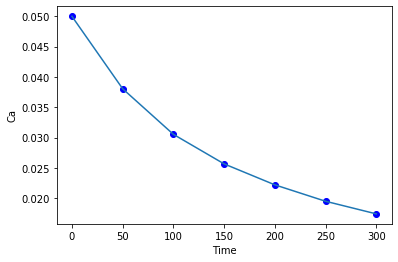

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time, Ca, 'bo', time, X @ a)
plt.xlabel('Time')
plt.ylabel('Ca')

We previously claimed that solving this equation was equivalent to minimizing the summed squared errors. Here we demonstrate that is consistent with our observation for the first parameter.



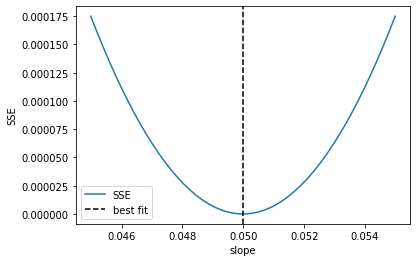

In [5]:
P = np.linspace(0.9 * a[0], 1.1 * a[0])

errs = [np.sum(np.square(X @ [p, *a[1:]] - Ca)) for p in P]

plt.plot(P, errs)
plt.axvline(a[0], color='k', linestyle='--')
plt.xlabel('slope')
plt.ylabel('SSE')
plt.legend(['SSE', 'best fit'])

**Exercise** Demonstrate that the SSE is minimized for the other parameters. Try estimating the Hessian of the sum of squared errors and then see if it is positive definite.

As we have seen many times before, Numpy provides a function for doing least squares linear regression. It returns more information about the fit than what we have done so far, and is a little more convenient because we do not have to do all the transposes and left multiplications.



In [6]:
?np.linalg.lstsq

In [7]:
pars, residuals, rank, singular_values = np.linalg.lstsq(X, Ca)
pars, residuals, rank, singular_values

/Users/jkitchin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


(array([ 4.99902596e-02, -2.97846320e-04,  1.34348484e-06, -3.48484840e-09,
         3.69696954e-12]),
 array([1.05194694e-08]),
 5,
 array([9.14856013e+09, 3.79175229e+06, 5.21123386e+03, 2.15423665e+01,
        1.00603128e+00]))

The key points to note are that the rank is equal to the number of parameters we are estimating, which means we have enough information to get pretty good estimates of the parameters.



### Confidence intervals on the parameters



The confidence intervals reflect the range of values we are confident the true parameter lies in. Remember we are only *estimating* these parameters from a small amount of data.

The degrees of freedom is roughly equal to the number of data points minus the number of parameters.

We define $\sigma^2 = SSE / dof$ where $SSE$ is the summed squared error, and $dof$ is the degrees of freedom.

The covariance matrix is defined as $(\mathbf{X}^T \mathbf{X})^{-1}$. Finally, we compute the standard error on the parameters as:

$\mathbf{se} = \sqrt{diag(\sigma^2 cov)}$.

This will be an array with one element for each parameter. You can think of this standard error as the uncertainty in the mean value of each parameter.

The confidence intervals are finally computed by calculating a student t-value that accounts for the additional uncertainty we have because of the small number of degrees of freedom.



In [8]:
dof = len(Ca) - len(pars)
errs = Ca - X @ pars
sigma2 = np.sum(errs**2) / dof

covariance = np.linalg.inv(X.T @ X)
se = np.sqrt(np.diag(sigma2 * covariance))

from scipy.stats.distributions import t
alpha = 0.05  # 100*(1 - alpha) confidence level
sT = t.ppf(1.0 - alpha/2.0, dof)  # student T multiplier

CI = sT * se

for beta, ci in zip(pars, CI):
    print(f'{beta: 1.2e} [{beta - ci: 1.4e} {beta + ci: 1.4e}]')

 5.00e-02 [ 4.9680e-02  5.0300e-02]
-2.98e-04 [-3.1546e-04 -2.8023e-04]
 1.34e-06 [ 1.0715e-06  1.6155e-06]
-3.48e-09 [-4.9032e-09 -2.0665e-09]
 3.70e-12 [ 1.3501e-12  6.0439e-12]


It is also common to estimate an $R^2$ value, where values close to one mean the model accounts for most of the variance in the data.



In [9]:
SS_tot = np.sum((Ca - np.mean(Ca))**2)
SS_err = np.sum(errs**2)

#  http://en.wikipedia.org/wiki/Coefficient_of_determination
Rsq = 1 - SS_err/SS_tot
print('R^2 = {0}'.format(Rsq))

R^2 = 0.9999869672459537


Here we would say the model looks very good, but with the caveat that we fit five parameters to seven data points, and some of the parameters are very small, suggesting they may not be necessary (although they are in front of terms like x<sup>4</sup> which can be very large).

Now you can use this model to interpolate new values in the fitted range. This is not a model you can extrapolate with though, *even though it is a linear model*. What is happening?



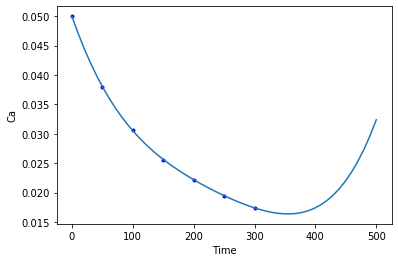

In [10]:
newt = np.linspace(0, 500)

newT = np.column_stack([newt**i for i in range(5)])
newCa = newT @ pars

plt.plot(time, Ca, 'b.')
plt.plot(newt, newCa)
plt.xlabel('Time')
plt.ylabel('Ca');

It is almost certainly not reasonable for the concentration of A to start increasing again after about 350 time units.



## Regularization



When we do linear regression we get a coefficient for every function in the model. However, there can be bad behavior with regular regression, especially for certain classes of functions, and when the functions are correlated with each other. To explore why this happens, we will look at some regression models of varying complexity. We start by looking at some data.



Text(0, 0.5, 'y')

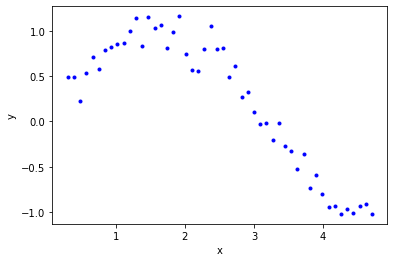

In [11]:
import numpy as np
np.random.seed(10)  #Setting seed for reproducibility

x = np.linspace(0.3, 1.5 * np.pi)
y = np.sin(x) + np.random.normal(0, 0.15, len(x))

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x, y, 'b.')
plt.xlabel('x')
plt.ylabel('y')

Our goal is to fit a linear regression model to this data. We want to avoid underfitting and overfitting. If we just fit polynomials to this data, we find some undesirable behavior. Let's look at fits up to a 12<sup>th</sup> order polynomials.



        x^12       x^11       x^10       x^9        x^8        x^7        x^6        x^5        x^4        x^3        x^2        x^1        x^0        
 1      0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00      -0.47       1.40
 3      0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.09      -0.92       2.08      -0.33
 6      0.00       0.00       0.00       0.00       0.00       0.00       0.01      -0.09       0.58      -1.80       2.37      -0.66       0.43
 9      0.00       0.00       0.00      -0.00       0.10      -1.02       5.90     -20.81      46.10     -63.24      50.45     -19.91       3.34
12      0.01      -0.21       2.83     -22.43     114.61    -395.70     940.66   -1541.20    1715.97   -1258.64     574.27    -144.86      15.53


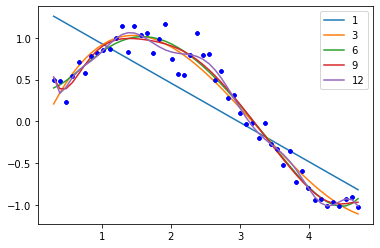

In [12]:
N = [1, 3, 6, 9, 12]

print('       ', f''.join([f'x^{i:<9d}' for i in range(12, -1, -1)]))

for i in N:
    pars = np.polyfit(x, y, i)
    p = np.zeros(13)
    p[13 - (i + 1):] = pars
    # This way of printing is to get columnar output
    print(f'{i:2d}', f'  '.join([f'{j: 9.2f}' for j in p]))
    plt.plot(x, y, 'b.')
    plt.plot(x, np.polyval(pars, x), label=f'{i}')
plt.legend()

The most undesirable behavior is that the coefficients grow large, which puts a lot of weight in places we might not want. This also leads to *wiggles* in the fit, which are probably not reasonable. The solution to this issue is called *regularization*, which means we add a penalty to our objective function that serves to reduce the magnitude of the parameters. There are several approaches to regularization. In *ridge regression* we add an L<sub>2</sub> penalty to the parameters, i.e. the sum of the parameters squared. In *LASSO* regression we add an L<sub>1</sub> penalty to the parameters, i.e. the sum of the absolute values of the parameters.

In *ridge regression* the parameters are driven by the penalty to become smaller. In *LASSO regression* as many of the parameters are driven to zero as possible.



### Ridge regression



In ridge regression we define our objective function to minimize the summed squared error as usual, and add a term proportional to the sum of the squared parameters.

So, if our regression model looks like $\mathbf{X} \mathbf{\beta} = \mathbf{y}$ we seek to minimize:

$(\mathbf{y} - \mathbf{X} \mathbf{p})^T (\mathbf{y} - \mathbf{X} \mathbf{p}) + \lambda ||\mathbf{p}||_2^2$

Where $\mathbf{p}$ are the fitting parameters, and $\lambda$ is the proportionality constant.

Finding the parameters is done by solving this modified normal equation:

$(\mathbf{Z}^T \mathbf{Z} + \lambda(\mathbf{I} \mathbf{p}) = \mathb{Z}^T \mathbf{w}$

We have changed variable names because it is considered important to standardize our variables:

$\mathbf{Z} = (\mathbf{X} - mean(\mathbf{X})) / std(\mathbf{X})$

Standardization means that the variable has a mean of 0 and a standard deviation of 1.
and

$\mathbf{w} = (\mathbf{y} - mean(\mathbf{y})) / std(\mathbf{y})$

&lambda; is a parameter that affects the amount of *regularization*.

It is common to *standardize* the input/output variables which means we make the average of each column equal to zero and scale them to have unit variance. Doing this eliminates the intercept from the model since it would then go through the point (0, 0).



In [13]:
X = np.vander(x, 12)[:, 0:-1] # since we standardize we do not consider the last column of ones.
xmean = X.mean(axis=0)  # average of every column
xstd = X.std(axis=0)
xmean, xstd

(array([2.48293800e+06, 5.69542539e+05, 1.31727857e+05, 3.07737861e+04,
        7.27890923e+03, 1.74895299e+03, 4.28974856e+02, 1.08219836e+02,
        2.84377137e+01, 7.96966389e+00, 2.50619449e+00]),
 array([5.49844745e+06, 1.19967517e+06, 2.62434616e+05, 5.75785285e+04,
        1.26746927e+04, 2.80017452e+03, 6.20905075e+02, 1.38066119e+02,
        3.06634869e+01, 6.68612694e+00, 1.29948184e+00]))

We standardize the input vector like this.



In [14]:
Z = (X - xmean) / xstd

Here we just confirm we have standardized all the columns. The only one that stands out is the column of ones, which does not have unit standard deviation.



In [15]:
with np.printoptions(suppress=True):
    print(Z.mean(axis=0), Z.std(axis=0))

[-0. -0.  0.  0.  0. -0.  0.  0.  0. -0.  0.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


We similarly standardize the y data.



In [16]:
ymean = y.mean()
ystd = y.std()

w = (y - ymean) / ystd

To get an estimate of the parameters we have to specify a value of &lambda;. If we set &lambda;=0, we have regular linear regression. If we set &lambda;=&infin;, all the weights will go to zero. We need something in between. It is a good idea to try several values of &lambda; from a very small value to a large value, on a log scale.



lambda      x^11         x^10         x^9          x^8          x^7          x^6          x^5          x^4          x^3          x^2          x^1          
       0    -34043.54   190691.01  -464362.98   645651.76  -566688.59   328402.49  -128144.25    33874.94    -6032.60      691.22      -40.28
   1e-13    -13149.13    64363.30  -129320.28   133383.30   -67613.99     5161.66    12758.58    -7038.91     1606.47     -156.63        4.82
 3.2e-10     -1054.80     3732.42    -3866.47     -865.34     3642.53     -286.76    -3426.18     3217.32    -1354.26      284.92      -24.21
   1e-06       -11.38        6.95       17.29        8.03      -18.81      -29.90       13.53       55.80      -61.16       19.93       -1.06
  0.0032        -0.28       -0.10        0.10        0.32        0.54        0.63        0.39       -0.43       -1.76       -2.04        1.87
      10         0.11        0.08        0.04       -0.01       -0.06       -0.11       -0.17       -0.22       -0.25       -0.22     

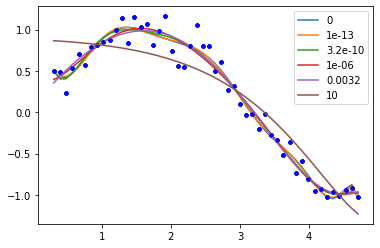

In [17]:
lambdas = np.concatenate([[0], np.geomspace(1e-13, 10, 5)])

print('lambda     ', f''.join([f'x^{i:<11d}' for i in range(len(X[0]), 0, -1)]))
for lam in lambdas:
    l2p = np.linalg.solve(Z.T @ Z + lam * np.eye(len(Z[0])), Z.T @ w)
    p = np.zeros(len(X[0]))
    p[len(X[0] + 2) - len(l2p):] = l2p
    # This way of printing is to get columnar output
    print(f'{lam:8.2g}', f''.join([f'{j: 12.2f}' for j in p]))
    plt.plot(x, y, 'b.')
    plt.plot(x, (Z @ l2p) * ystd + ymean, label=f'{lam:1.2g}')
plt.legend()

One way people have evaluated a reasonable value of &lambda; is to look at how the coefficients vary with &lambda; using a *ridge plot*. In this plot, you look for a range that balances the large swings associated with regular unconstrained regression and the damping caused by large values of &lambda;. Here a value of $10^{-6} \le \lambda \le 10^{-8}$ would be considered reasonable.



Text(0, 0.5, 'parameters')

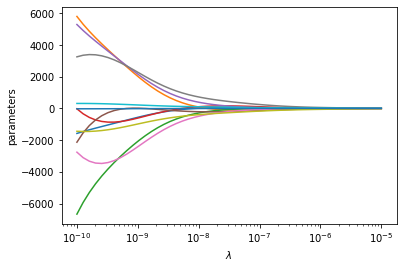

In [18]:
lambdas = np.geomspace(1e-10, 1e-5)

pars = np.zeros((11, len(lambdas)))

for i, lam in enumerate(lambdas):
    l2p = np.linalg.solve(Z.T @ Z + lam * np.eye(len(Z[0])), Z.T @ w)
    pars[:, i] = l2p

plt.semilogx(lambdas, pars.T)
plt.xlabel(r'$\lambda$')
plt.ylabel('parameters')

### LASSO regression



In LASSO regression, we seek to minimize the summed squared errors *plus* the sum of the absolute value of the parameters. Unlike linear least squares regression and ridge regression, there is no analytical solution to get the parameters; they can only be obtained numerically using an iterative solver. We again have a parameter &lambda; we have to choose. Setting this parameter to zero will be equivalent to normal linear regression. Setting this parameter to infinity will again cause all coefficients to go to zero. We again have to find a balance.



Optimization terminated successfully. [-0.825  1.61   0.     0.967  0.963 -2.048 -1.275 -0.371 -0.003  0.
  0.182]


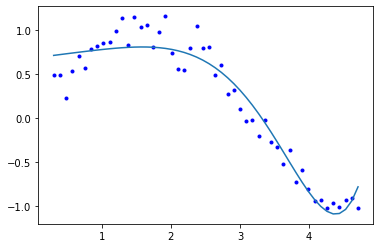

In [19]:
def objective(pars, lam=0.0):
    SSE = np.sum(np.square(y - ((Z @ pars) * ystd + ymean)))
    return SSE + lam * np.sum(np.abs(pars))

from scipy.optimize import minimize
sol = minimize(objective, np.random.random(len(Z[0])), (0.15,),
               method='nelder-mead', options={'maxiter': 5000})

np.set_printoptions(suppress=True, precision=3) # prints small numbers as practically zero
print(sol.message, sol.x)

plt.plot(x, y, 'b.')
plt.plot(x, (Z @ sol.x) * ystd + ymean)

Now, we can explore the effect of &lambda; more thoroughly.



lambda      x^11         x^10         x^9          x^8          x^7          x^6          x^5          x^4          x^3          x^2          x^1          
       0       139.52     -305.66       -1.39      299.39      110.45     -331.42     -179.76      525.79     -342.97       94.08       -8.82
   1e-05        62.46     -142.89      -10.47      185.71       19.28     -169.52      -95.37      309.18     -214.68       60.95       -5.42
 0.00032         0.06        0.03       -0.00       -0.32       -0.00       -0.00        2.01        2.06       -6.19       -0.00        1.58
    0.01        -0.04       -0.00       -0.00        0.00        0.46        0.66        0.00       -0.00       -1.07       -2.85        2.07
    0.32         0.38        0.19        0.00        0.00       -0.00       -0.00       -0.00       -0.00       -1.97       -0.00        0.60
      10        -0.00       -0.00       -0.00       -0.00       -0.01       -0.00       -0.05       -0.03       -0.07       -0.57     

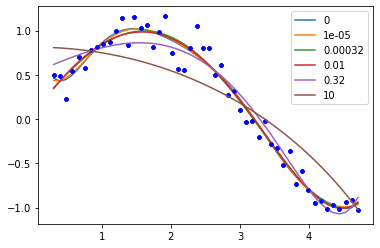

In [20]:
lambdas = np.concatenate([[0], np.geomspace(1e-5, 10, 5)])

print('lambda     ', f''.join([f'x^{i:<11d}' for i in range(len(X[0]), 0, -1)]))
for lam in lambdas:
    sol = minimize(objective, np.random.random(len(Z[0])), (lam,),
                   options={'maxiter': 5000})

    # This way of printing is to get columnar output
    print(f'{lam:8.2g}', f''.join([f'{j: 12.2f}' for j in sol.x]))
    plt.plot(x, y, 'b.')
    plt.plot(x, (Z @ sol.x) * ystd + ymean, label=f'{lam:1.2g}')
plt.legend()

You can see that by increasing &lambda; we are making more and more of the parameters go to zero; in other words the functions they correspond to are not part of the model any longer. This is called sparsifying the model. It reduces over-fitting by reducing the model complexity. Finding the most suitable value for &lambda; requires some sophisticated programming and analysis, and it is an important topic in machine learning and data science.

LASSO has some important benefits, and some disadvantanges. The benefits include sparsification of the model; the method removes inputs that are not needed, or that are highly correlated with other inputs. This can make models more interpretable as there are fewer terms, and the terms are more independent.

The disadvantages, however, are that we cannot use linear algebra to find the parameters. The penalty imposes a nonlinear behavior to the objective function, so we must use an iterative solver. For features that are correlated, we have no control over which feature is eliminated. Different initial guesses may lead to different feature elimination. If the features are really correlated, this will not affect the fit quality, but it will mean some models favor one feature over another. This is less of a problem in polynomial models, but often a problem in models based on physical properties that are correlated, e.g. high melting points of materials tend to be correlated with how hard they are. With LASSO, one model could favor the melting point and another could favor the hardness.



### Advanced selection of \lambda



A more advanced way to select a value of &lambda; is called k-fold validation. It is complex to code this, and the standard method to do it is in [scikit-learn](https://scikit-learn.org/stable/index.html), see specifically the [ridge regression example](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) and the  [LASSO example](https://scikit-learn.org/stable/modules/linear_model.html#lasso). The basic idea is that you split your data set into $k$ *folds*, and then you fit $k-1$ folds to get the paramters. On the remaining fold (which was not used for fitting) you estimate the model errors. Initially with no regularization, the errors will be high due to overfitting. As you add regularization, the errors will begin decrease. Eventually though, the model will start underfitting, and the errors will go back up. The &lambda; that provides the lowest test errors is usually considered the best choice.

We will not cover these more advanced methods as they rely on learning the scikit-learn API in depth, and some other higher level Python libraries we have not covered like Pandas. These are more appropriate in a data science/machine learning focused course.



## Summary



In this lecture we introduced the concept of linear regression. In the normal linear regression, we simply solve linear equations that ultimately minimize the summed squared errors between the model and data. With some additional linear algebra, we can also estimate the confidence intervals on the parameters.

One issue with normal linear regression is that the parameters are unconstrained, which can lead to some functions having undesirably large parameters. We introduced two types of *regularization* to mitigate this issue: ridge regression and LASSO regression. In both cases, a penalty function is added to the objective function being minimized. In ridge regression the penalty is an L2 norm on the parameters which penalizes large parameters, leading to a reduction in their magnitude. In LASSO reduction the penalty is an L1 norm, which drives parameters towards zero. Both methods rely on a hyperparameter &lambda; that determines how much regularization is applied. With both regularization approaches we have to use some judgment in how much regularization to apply (the magnitude of &lambda;), and we only provided a heuristic approach to doing this.

